# Team: Ioana Lupascu, Kevin Deng, Yuanyuan Teng

# Pokemon Challenge: Using Machine Learning to Predict Combat Winners

First we import relevant libraries for stats and machine learning

In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

THE DATASET WE WILL BE ANALYZING HAS THESE COLUMNS

HP : health of pokemon
Attack : attack power of pokemon
Defense : defense power of pokemon
Sp. Atk : special attack power of pokemon
Sp. Def : special defence power of pokemon
Speed : speed of pokemon


In [10]:
# This section is reading in the dataset and looking at the shape of our data
pokemon = pd.read_csv('pokemon.csv')
combats = pd.read_csv('combats.csv')
tests = pd.read_csv('tests.csv')
print(pokemon.columns)
print(combats.columns)
print(tests.columns)

print(pokemon.shape)
print(combats.shape)
print(tests.shape)

Index(['#', 'Name', 'Type 1', 'Type 2', 'HP', 'Attack', 'Defense', 'Sp. Atk',
       'Sp. Def', 'Speed', 'Generation', 'Legendary'],
      dtype='object')
Index(['First_pokemon', 'Second_pokemon', 'Winner'], dtype='object')
Index(['First_pokemon', 'Second_pokemon'], dtype='object')
(800, 12)
(50000, 3)
(10000, 2)


In [11]:
pokemon.head()

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


TypeError: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

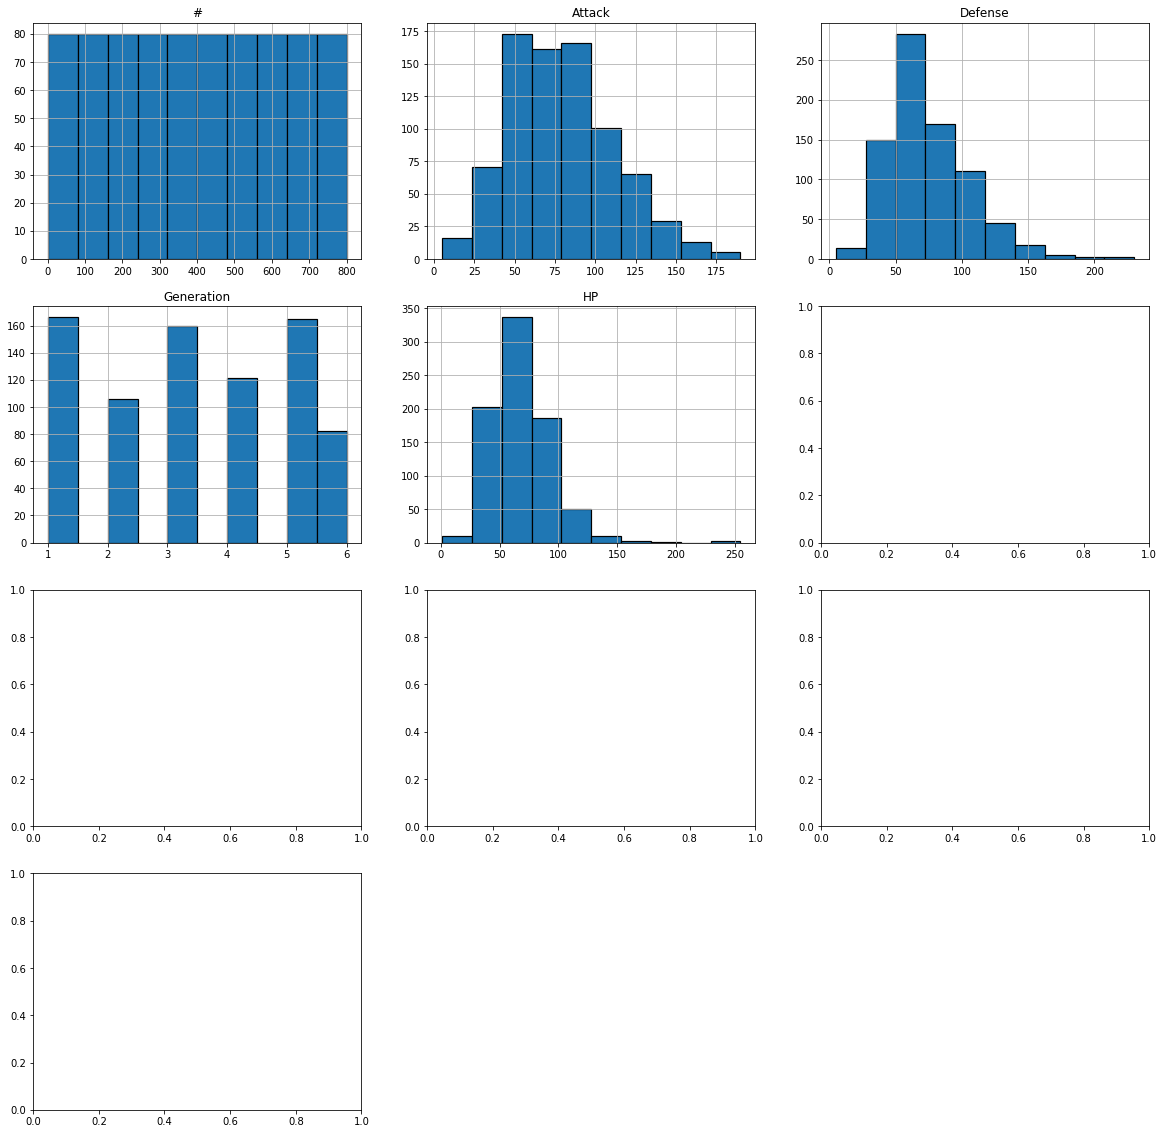

In [44]:
#Histogram to understand the distribution of numerical variables
pokemon.hist(edgecolor='black', linewidth=1.2, figsize=(20, 20))
plt.show()

In [12]:
combats.head()

,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151


# DATA EXPLORATION

First we look at the charactersitics of the Pokemon

First we look at the distribution of our Pokemon characteristics

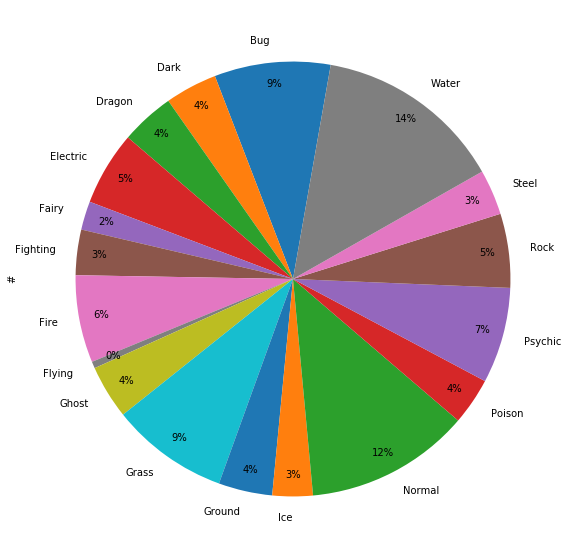

In [51]:
plt.figure(figsize=(10,10))
pokemon.groupby(['Type 1'])['#'].count().plot.pie(autopct='%1.0f%%', pctdistance=0.9, labeldistance=1.1, startangle=80)


Types of Pokemon. This looks at both types.

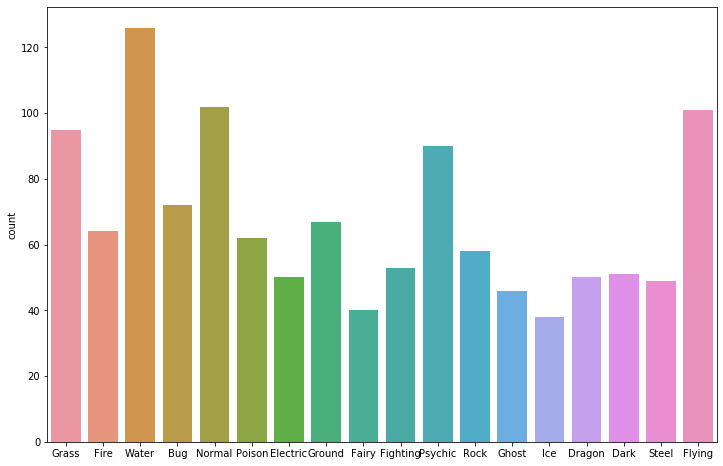

In [14]:
all_types = pokemon['Type 1'].append(pokemon['Type 2'][pd.isna(pokemon['Type 2']) != True])
fig,ax = plt.subplots(figsize=(12,8))
sns.countplot(all_types,ax=ax)
plt.show()

In [15]:
#creating a column for all the Totals of strengths
pokemon['Total'] = pokemon['HP'] + pokemon['Attack'] + pokemon['Defense'] + pokemon['Sp. Atk'] + pokemon['Sp. Def'] + pokemon['Speed']

In [16]:
#creating generations of Pokemon
generations = pokemon.groupby('Generation')[['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Legendary']].mean()

Viewing Type distributions of Legendary and Non-legendary Pokemon

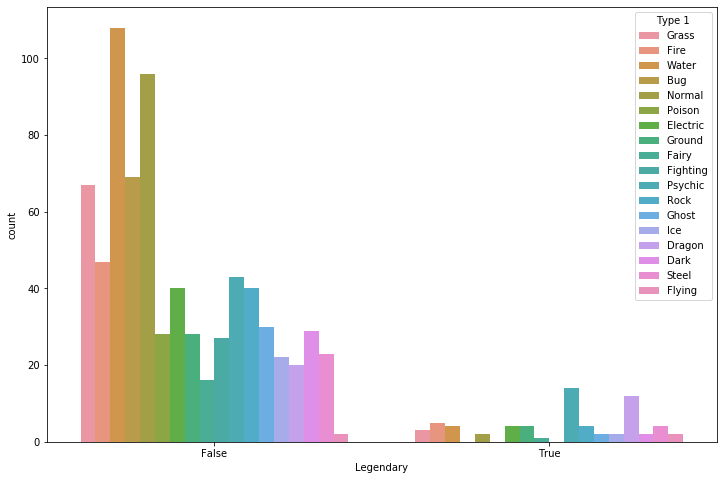

In [17]:
fig,ax = plt.subplots(figsize=(12,8))
sns.countplot(pokemon.Legendary,hue=pokemon["Type 1"],ax=ax)
plt.show()

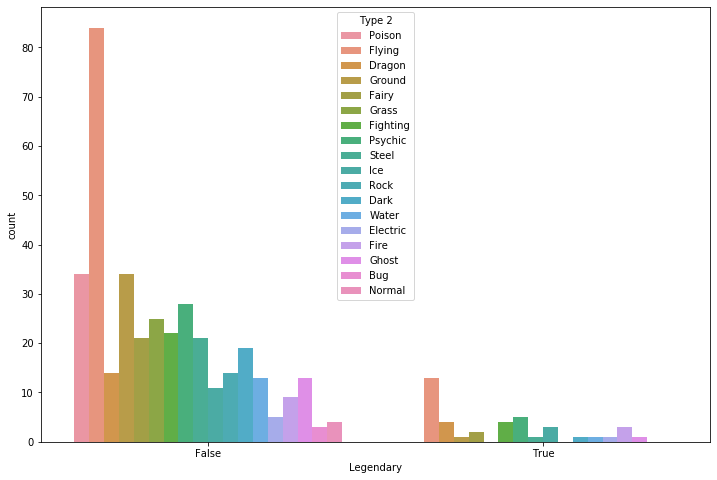

In [18]:
fig,ax = plt.subplots(figsize=(12,8))
sns.countplot(pokemon.Legendary,hue=pokemon["Type 2"],ax=ax)
plt.show()

The following graphs show the distributions of attack and defense poweres for Legendary and Non-legendary Pokemon

Text(125, 150, 'Legendary')

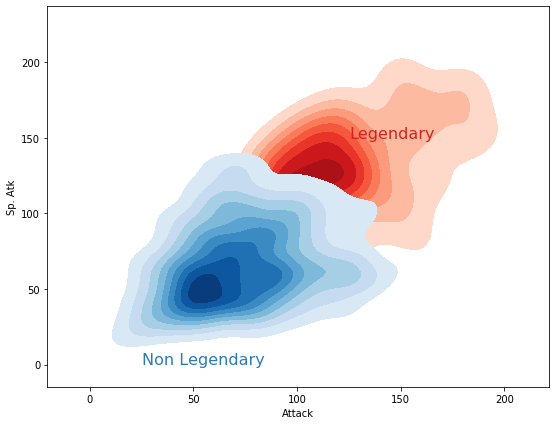

In [22]:
fig, ax = plt.subplots(figsize=(9, 7))
# Draw the two density plots
legendary = pokemon[pokemon.Legendary == True]
not_legendary = pokemon[pokemon.Legendary == False]

ax = sns.kdeplot(legendary['Attack'], legendary['Sp. Atk'],
                 cmap="Reds", shade=True, shade_lowest=False)
ax = sns.kdeplot(not_legendary['Attack'], not_legendary['Sp. Atk'],
                 cmap="Blues", shade=True, shade_lowest=False)

# Add labels to the plot
red = sns.color_palette("Reds")[-2]
blue = sns.color_palette("Blues")[-2]
ax.text(25, 0, "Non Legendary", size=16, color=blue)
ax.text(125, 150, "Legendary", size=16, color=red)

Text(125, 150, 'Legendary')

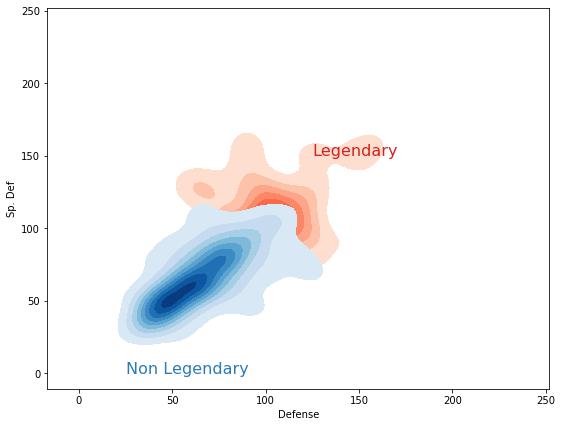

In [20]:
fig, ax = plt.subplots(figsize=(9, 7))
# Draw the two density plots
legendary = pokemon[pokemon.Legendary == True]
not_legendary = pokemon[pokemon.Legendary == False]

ax = sns.kdeplot(legendary['Defense'], legendary['Sp. Def'],
                 cmap="Reds", shade=True, shade_lowest=False)
ax = sns.kdeplot(not_legendary['Defense'], not_legendary['Sp. Def'],
                 cmap="Blues", shade=True, shade_lowest=False)

# Add labels to the plot
red = sns.color_palette("Reds")[-2]
blue = sns.color_palette("Blues")[-2]
ax.text(25, 0, "Non Legendary", size=16, color=blue)
ax.text(125, 150, "Legendary", size=16, color=red)

# DATA PROCESSING FOR MACHINE LEARNING


First we have to set up our data to set up for predctions later

In [23]:
#Making two different data frames to be merged later

first = pokemon.copy()
second = pokemon.copy()

In [24]:
first.head()

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Total
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False,318
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False,405
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False,525
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False,625
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False,309


Merging in data for the First and Second Pokemon, which will face off in Battle predictions later

In [25]:
first.columns = ['P1_Number', 'P1_Name', 'P1_Type 1', 'P1_Type 2', 'P1_HP', 'Attack_1', 'Defense_1', 'Sp. Atk_1',
       'Sp. Def_1', 'Speed_1', 'Generation_1', 'Legendary_1', 'Total_1']
second.columns = ['P2_Number', 'P2_Name', 'P2_Type 1', 'P2_Type 2', 'P2_HP', 'Attack_2', 'Defense_2', 'Sp. Atk_2',
        'Sp. Def_2', 'Speed_2', 'Generation_2', 'Legendary_2', 'Total_2']

#merging in data from first and second pokemon
merged = pd.merge(combats, first, left_on='First_pokemon', right_on='P1_Number')
merged = pd.merge(merged, second, left_on='Second_pokemon', right_on='P2_Number')

merged['P1_Type 1'] = merged['P1_Type 1'].astype('category').cat.codes.astype('category')
merged['P1_Type 2'] = merged['P1_Type 2'].astype('category').cat.codes.astype('category')
merged['P2_Type 1'] = merged['P2_Type 1'].astype('category').cat.codes.astype('category')
merged['P2_Type 2'] = merged['P2_Type 2'].astype('category').cat.codes.astype('category')

#label for whether the first pokemon wins (1 if true, 0 otherwise)
merged['First_win'] = merged['First_pokemon'] == merged['Winner']
merged['First_win'] = merged['First_win'].astype('category').cat.codes

merged = merged[['P1_Type 1', 'P1_Type 2', 'P1_HP', 'Attack_1', 'Defense_1', 'Sp. Atk_1',
       'Sp. Def_1', 'Speed_1', 'Generation_1', 'Legendary_1', 'Total_1',
       'P2_Type 1', 'P2_Type 2', 'P2_HP', 'Attack_2', 'Defense_2', 'Sp. Atk_2',
       'Sp. Def_2', 'Speed_2', 'Generation_2', 'Legendary_2', 'Total_2', 'First_win']]
merged.dtypes

P1_Type 1       category
P1_Type 2       category
P1_HP              int64
Attack_1           int64
Defense_1          int64
Sp. Atk_1          int64
Sp. Def_1          int64
Speed_1            int64
Generation_1       int64
Legendary_1         bool
Total_1            int64
P2_Type 1       category
P2_Type 2       category
P2_HP              int64
Attack_2           int64
Defense_2          int64
Sp. Atk_2          int64
Sp. Def_2          int64
Speed_2            int64
Generation_2       int64
Legendary_2         bool
Total_2            int64
First_win           int8
dtype: object

Splitting the data into X and Y, and then Train and Test sets to be used in prediction in the following models

In [27]:
x = merged.drop('First_win', axis = 1)
print(merged.columns)
y = merged['First_win']

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.3, random_state = 1010)

Index(['P1_Type 1', 'P1_Type 2', 'P1_HP', 'Attack_1', 'Defense_1', 'Sp. Atk_1',
       'Sp. Def_1', 'Speed_1', 'Generation_1', 'Legendary_1', 'Total_1',
       'P2_Type 1', 'P2_Type 2', 'P2_HP', 'Attack_2', 'Defense_2', 'Sp. Atk_2',
       'Sp. Def_2', 'Speed_2', 'Generation_2', 'Legendary_2', 'Total_2',
       'First_win'],
      dtype='object')


# MACHINE LEARNING MODEL 1: LOGISTIC REGRESSION

In [28]:
############# Logistic Regression
LR = LogisticRegression(max_iter=1000)
LR.fit(xtrain, ytrain)
ypred = LR.predict(xtest)
acc_LR = accuracy_score(ypred, ytest)
report_LR = classification_report(y_pred = ypred, y_true = ytest, output_dict = True)
#print(report_LR['1'])

print("Logistic Regression Classification report:")
print("\tAccuracy:", acc_LR)
print("\tPrecision:",report_LR['1']['precision'])
print("\tRecall:",report_LR['1']['recall'])
print("\tF1_Score:",report_LR['1']['f1-score'])

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression Classification report:
	Accuracy: 0.8863333333333333
	Precision: 0.884756269371654
	Recall: 0.8762383144970002
	F1_Score: 0.8804766912022434


Evaluating the model

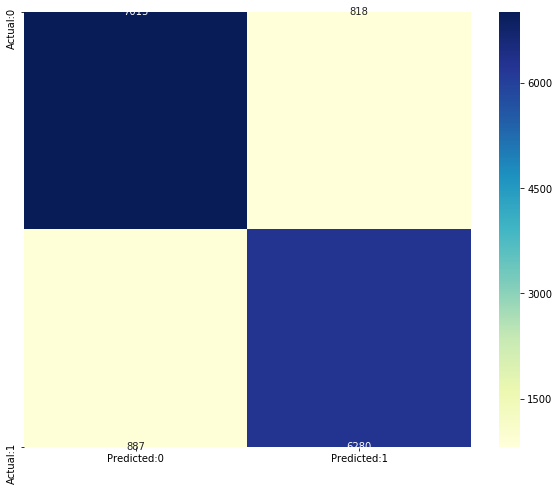

In [29]:
cm = confusion_matrix(ytest,ypred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="YlGnBu")
plt.show()

# MACHINE LEARNING MODEL 2: RANDOM FOREST

In [33]:
rf = RandomForestClassifier()
# search the best params
grid = {'n_estimators':[100,200], 'max_depth': [10,20,50]}

#gridsearch will search through different parameters
#tests with 100 estimators, then through max depth

pokemon_rf = GridSearchCV(rf, grid, cv=10)
pokemon_rf.fit(xtrain, ytrain)

Y_pred_rf = pokemon_rf.predict(xtest)
# get the accuracy score
acc_rf = accuracy_score(Y_pred_rf, ytest)
print(acc_rf)

0.9419333333333333


# Validating the Random Forest Model

In [47]:

new_test=tests[["First_pokemon","Second_pokemon"]].replace(pokemon.Name) #creates new test file with Pokemon names
new_test.head()

,First_pokemon,Second_pokemon
0,Staryu,Koffing
1,Klink,Espeon
2,Reshiram,Hitmonchan
3,Ampharos,Dwebble
4,Fearow,Joltik


In [53]:
#pred=pokemon_rf.predict(new_test)
#new_test["Winner"]=[new_test["First_pokemon"][i] if pred[i]==0 else new_test["Second_pokemon"][i] for i in range(len(pred))]

In [34]:
report_RF = classification_report(y_pred = Y_pred_rf, y_true = ytest, output_dict = True)
print("Random Forest Classification report:")
print("\tAccuracy:", acc_rf)
print("\tPrecision:",report_RF['1']['precision'])
print("\tRecall:",report_RF['1']['recall'])
print("\tF1_Score:",report_RF['1']['f1-score'])

Random Forest Classification report:
	Accuracy: 0.9419333333333333
	Precision: 0.9371008053318522
	Recall: 0.9416771312962188
	F1_Score: 0.9393833948082678


Evaluating the Model

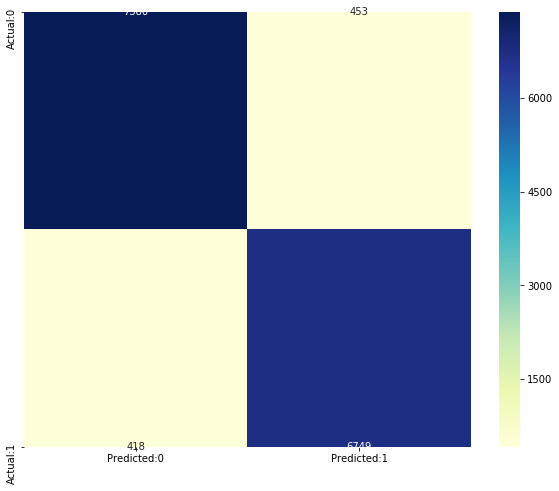

In [35]:
cm = confusion_matrix(ytest,Y_pred_rf)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="YlGnBu")
plt.show()

# MACHINE LEARNING MODEL 3: K NEAREST NEIGHBORS

Generating the Model

In [36]:
knn = KNeighborsClassifier()

# values we want to test for n_neighbors
knn_grid = {'n_neighbors': np.arange(20, 50)}

pokemon_knn = GridSearchCV(knn, knn_grid, cv=5)

#fit model to data
pokemon_knn.fit(xtrain, ytrain)

ypred_knn = pokemon_knn.predict(xtest)
# get the accuracy score
acc_knn = accuracy_score(ypred_knn, ytest)
print("KNN Accuracy:", acc_knn)

KNN Accuracy: 0.8618


Evaluating the Model

In [37]:
report_KNN = classification_report(y_pred = ypred_knn, y_true = ytest, output_dict = True)
print("KNN Classification report:")
print("\tAccuracy:", acc_knn)
print("\tPrecision:",report_KNN['1']['precision'])
print("\tRecall:",report_KNN['1']['recall'])
print("\tF1_Score:",report_KNN['1']['f1-score'])

KNN Classification report:
	Accuracy: 0.8618
	Precision: 0.8587323943661972
	Recall: 0.8507046183898423
	F1_Score: 0.8546996565500805
